# PE Resolution Classification

We perform a univariable classifications using each explanatory variable. We then perform multivariable classifications. For these, we focus on body composition only, cardiopulmonary features only, and then a composite model. For each of these, we perform three forms of feature selection, using (1) recursive feature elimination with cross validation, (2) forward sequential feature selection with cross validation, and (3) backward feature selection with cross validation. For these groups of selected features, we also perform sensitivities controlling for gender, age, and both gender and age.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm.notebook import trange, tqdm
from config import model_config

from scipy.stats import shapiro
from sklearn.ensemble import (
	RandomForestClassifier
)
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression,
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
	roc_curve, roc_auc_score, auc, RocCurveDisplay
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score, cross_val_predict, KFold, StratifiedKFold
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer,
)
import statsmodels.api as sm
from xgboost import XGBClassifier

from regression import reg

In [141]:
SEED = 123
TEST_SIZE = 0.25
CV_FOLDS = 5

HEATMAP_COLORS = sns.diverging_palette(h_neg=359, h_pos=250, as_cmap=True)
plt.style.use('ggplot')

USE_INITIAL = True
USE_CLUSTERED_SE = False

# Import Data

In [74]:
if USE_INITIAL:
    with open(Path('../data/classification_data_initial.pkl'), 'rb') as f:
    	data = pickle.load(f)
else:
    with open(Path('../data/classification_data_all.pkl'), 'rb') as f:
    	data = pickle.load(f)
	
X = data.get('X')
y = data.get('y').squeeze()
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')
control_features = data.get('controls')
all_features = body_features + cardio_features + control_features

print(X.shape)
print(y.shape)
print(body_features)
print(cardio_features)
print(control_features)

(43, 17)
(43,)
['density_visceral_fat', 'density_intermuscular_fat', 'volume_bone', 'density_bone', 'bmi']
['emphysema_volume_950hu', 'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv10', 'pb_larger_10', 'a_diameter', 'pv_a', 'heart_volume', 'airway_ratio', 'ild_volume']
['age', 'gender_cl_Male']


In [75]:
pe_numbers = y.index.str[:-2]
pe_numbers

Index(['PE1', 'PE12', 'PE14', 'PE15', 'PE16', 'PE17', 'PE18', 'PE19', 'PE2',
       'PE20', 'PE21', 'PE22', 'PE23', 'PE24', 'PE25', 'PE27', 'PE28', 'PE3',
       'PE31', 'PE32', 'PE33', 'PE34', 'PE35', 'PE36', 'PE37', 'PE4', 'PE40',
       'PE41', 'PE42', 'PE43', 'PE44', 'PE45', 'PE47', 'PE48', 'PE49', 'PE5',
       'PE51', 'PE52', 'PE53', 'PE6', 'PE7', 'PE8', 'PE9'],
      dtype='object')

In [76]:
y.head(2)

PE1_0     1
PE12_0    0
Name: resolved_pe, dtype: int64

In [77]:
y.value_counts(dropna=False)

0    28
1    15
Name: resolved_pe, dtype: int64

# Logit Regression Functions

In [78]:
def get_params(model, X, y):
    """Returns pd.Series of coefs for comparison with statsmodels params."""
    y = np.array(y).ravel()
    model.fit(X, y)
    coef = pd.Series(np.squeeze(model.coef_), index=np.squeeze(model.feature_names_in_))
    # coef['const'] = model.intercept_
    return coef.sort_index()

In [79]:
def backward_stepwise_selection(X, y, cutoff):
    # Make copies of X, y
    X_temp = sm.add_constant(X.copy())
    y_temp = y.copy()
    
    # Fit initial model
    if USE_CLUSTERED_SE:
        model_sm = sm.Logit(y_temp, X_temp).fit(cov_type='cluster', disp=False, cov_kwds={'groups': pe_numbers})
    else: 
        model_sm = sm.Logit(y_temp, X_temp).fit(cov_type='HC3', disp=False)
        
        
    coefs = model_sm.params[1:]
    pvals = model_sm.pvalues[1:]
    df_temp = pd.DataFrame({
        'coefs': coefs,
        'pvals': pvals
    })
    current_varlist = list(coefs.index.values)

    # Store progression in a list of lists
    progression = list()
    progression.append(dict(zip(coefs.index.values, zip(coefs.values, pvals.values))))
    
    # Iterate until all are stat signif
    while not np.all(df_temp['pvals'] < cutoff):
        
        # Drop the variable with the highest pvalue
        new_vars = df_temp.drop(index=df_temp['pvals'].idxmax()).index.values
        
        # If remaining varlist is empty, break and return the last regression results
        if len(new_vars) == 0:
            break

        # Subset X to new list of variables
        X_temp = sm.add_constant(X_temp.loc[:, new_vars])
        
        # Re-fit model
        if USE_CLUSTERED_SE:
            model_sm = sm.Logit(y_temp, X_temp).fit(cov_type='cluster', disp=False, cov_kwds={'groups': pe_numbers})
        else: 
            model_sm = sm.Logit(y_temp, X_temp).fit(cov_type='HC3', disp=False)
            
        coefs = model_sm.params[1:]
        pvals = model_sm.pvalues[1:]
        df_temp = pd.DataFrame({
            'coefs': coefs,
            'pvals': pvals
        })
        progression.append(dict(zip(coefs.index.values, zip(coefs.values, pvals.values))))
        current_varlist = [var for var in model_sm.params.index.values if var != 'const']
    
    return current_varlist, progression

# Example
feat_out, prog = backward_stepwise_selection(X[cardio_features], y, 0.05)
print(feat_out)

['a_diameter']


In [80]:
def model_residual_correlation(model):
    """Returns measure of correlation."""
    return np.corrcoef(np.arange(len(model.resid)), model.resid)[1, 0]

In [81]:
def fit_model(X, y):
    """Fit statsmodels OLS model with robust SEs and sklearn OLS model."""
    # Fit statsmodels model for pvalues and coef
    
    if USE_CLUSTERED_SE:
        model_sm = sm.Logit(y, X).fit(cov_type='cluster', disp=False, cov_kwds={'groups': pe_numbers})
    else: 
        model_sm = sm.Logit(y, X).fit(cov_type='HC3', disp=False)

    # Define sklearn model for CV evaluation
    model_sk = LogisticRegression(
        random_state=SEED,
        fit_intercept=False,
        max_iter=10_000, 
        tol=0.000001,
        penalty=None, 
        solver='newton-cg',
    )
    # Check that model params match
    # print(get_params(model_sk, X, y))
    # print(model_sm.params.sort_values())
    # print(np.isclose(get_params(model_sk, X, y), model_sm.params.sort_values()))
    assert np.all(np.isclose(get_params(model_sk, X, y), model_sm.params.sort_index()))
    model_sk.fit(X, y)
    return model_sm, model_sk

In [82]:
def store_model_results(model_sm, model_sk, X, y):
    """
    Params:
        - model_sm: statsmodel model for coefs, pvalues, and residuals.
        - model_sk: sklearn model for cross validation
        - X: X data.
        - y: y data.
    """
    # Calculate CV scores
    cv_scores = cross_val_score(
        model_sk, X, y, 
        scoring='roc_auc', 
        cv=CV_FOLDS, n_jobs=-1
    )
    # Store model results
    model_results = pd.DataFrame(
        {
            'y': y.name,
            'model_dfn': [tuple(X.columns.values)],
            'nobs': model_sm.nobs,
            'shapiro_resid_pvalue': np.nan,
            'metric_train': model_sk.score(X, y),
            'metric_cv_mean': np.mean(np.abs(cv_scores)),
            'metric_cv_std': np.std(cv_scores),
        }
    )
    # Set model index
    model_results = model_results.set_index(['y', 'model_dfn'])
    return model_results

In [83]:
def store_coef_results(model_sm, y):
    """
    Params:
        - model_sm: statsmodel model for coefs, pvalues, and residuals.
        - y: y data.
    """
    results = pd.DataFrame(
        {
            'model_dfn': [tuple(model_sm.params.index) for _ in range(len(model_sm.params))],
            'coef': model_sm.params, 
            'pval': model_sm.pvalues,
        },
    )
    results['signif'] = results['pval'].apply(reg.add_significance)
    results = results.reset_index(names='x')
    results['y'] = y.name
    results = results.pivot(index=['y', 'model_dfn'], columns=['x'], values=['coef', 'pval', 'signif'])
    results.columns = ['_'.join(idx) for idx in results.columns]
    return results

In [84]:
def combine_model_results(model_sm, model_sk, X, y):
    model_results = store_model_results(model_sm, model_sk, X, y)
    coef_results = store_coef_results(model_sm, y)
    assert model_results.shape[0] == coef_results.shape[0] 
    combined_results = pd.concat([model_results, coef_results], axis=1)
    return combined_results

## Example

In [85]:
target = 'resolved_pe'
features = 'pv_a'
X_temp = sm.add_constant(X[features])
y_temp = y.copy()
model_sm, model_sk = fit_model(X_temp, y_temp)

In [86]:
store_model_results(model_sm, model_sk, X_temp, y_temp)

,,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std
y,model_dfn,,,,,
resolved_pe,"(const, pv_a)",43,NaN,0.651163,0.322222,0.084911


In [87]:
store_coef_results(model_sm, y_temp)

,,coef_const,coef_pv_a,pval_const,pval_pv_a,signif_const,signif_pv_a
y,model_dfn,,,,,,
resolved_pe,"(const, pv_a)",-0.615301,0.049307,0.059421,0.899261,,


In [88]:
model_sk.predict(sm.add_constant(X[features]))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [89]:
target = 'resolved_pe'
# features = ['pv_a']
# features = ['density_bone', 'pv_a']
# features = ['density_bone', 'a_diameter', 'pv_a', 'age', 'gender_cl_Male']
features = ['density_bone', 'pv_a', 'gender_cl_Male']

X_temp = sm.add_constant(X[features])
y_temp = y.copy()

# Statsmodels
if USE_CLUSTERED_SE:
    model = sm.Logit(y_temp, X_temp).fit(cov_type='cluster', disp=False, cov_kwds={'groups': pe_numbers})
else: 
    model = sm.Logit(y_temp, X_temp).fit(cov_type='HC3', disp=False)
    
print(pd.DataFrame({"coefs": model.params, "pvals": model.pvalues}))

# Sklearn 
model_sk = LogisticRegression(
        random_state=SEED,
        fit_intercept=False,
        max_iter=10_000, 
        tol=0.000001,
        penalty=None, 
        solver='newton-cg',
)
model_sk.fit(X_temp, y_temp)
cv_scores = cross_val_score(model_sk, X_temp, y_temp, scoring='roc_auc', cv=CV_FOLDS, n_jobs=-1)
print(model_sk.coef_)
print(np.mean(cv_scores))

                   coefs     pvals
const          -1.016710  0.017246
density_bone   -0.650677  0.105937
pv_a            0.325144  0.463565
gender_cl_Male  0.837730  0.016510
[[-1.01670981 -0.65067658  0.32514398  0.83773037]]
0.7711111111111112


# Perform univariable regressions 

In [90]:
univariate_models = pd.DataFrame()
univariate_coefs = pd.DataFrame()

for feature in tqdm(all_features):
    # Fit model
    X_temp = sm.add_constant(X[feature])
    y_temp = y.copy()
    try:
        model_sm, model_sk = fit_model(X_temp, y_temp)
    except:
        print(f"Logit on {feature} failed to converge")
        continue
    # Collect model information
    univariate_models = pd.concat([univariate_models, store_model_results(model_sm, model_sk, X_temp, y_temp)], 
                                  axis=0)

    # Collect coef information
    univariate_coefs = pd.concat([univariate_coefs, store_coef_results(model_sm, y_temp)], 
                                 axis=0)
    
print(univariate_models.shape)
print(univariate_coefs.shape)

  0%|          | 0/17 [00:00<?, ?it/s]

(17, 5)
(17, 54)


In [91]:
univariate_results = univariate_models.join(univariate_coefs, how='left', validate='1:1')
univariate_results = univariate_results.reset_index()
univariate_results['selection_method'] = 'All'
univariate_results['model_dfn'] = univariate_results['model_dfn'].apply(lambda x: x[1])
univariate_results['category'] = 'univariable_' + univariate_results['model_dfn']
univariate_results['controls'] = 'None'
univariate_results.index = univariate_results[['category', 'selection_method', 'y', 'controls']].apply('%'.join, axis=1)
univariate_results.index.name = 'Lookup'
print(univariate_results.shape)
univariate_results

(17, 64)


,y,model_dfn,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std,coef_const,coef_density_visceral_fat,pval_const,...,signif_ild_volume,coef_age,pval_age,signif_age,coef_gender_cl_Male,pval_gender_cl_Male,signif_gender_cl_Male,selection_method,category,controls
Lookup,,,,,,,,,,,,,,,,,,,,,
univariable_density_visceral_fat%All%resolved_pe%None,resolved_pe,density_visceral_fat,43,NaN,0.627907,0.570000,0.142794,-0.678737,-0.282329,0.036291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_density_visceral_fat,None
univariable_density_intermuscular_fat%All%resolved_pe%None,resolved_pe,density_intermuscular_fat,43,NaN,0.651163,0.350000,0.183720,-0.624545,NaN,0.051216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_density_intermuscular_fat,None
univariable_volume_bone%All%resolved_pe%None,resolved_pe,volume_bone,43,NaN,0.627907,0.548889,0.239093,-0.755424,NaN,0.030291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_volume_bone,None
univariable_density_bone%All%resolved_pe%None,resolved_pe,density_bone,43,NaN,0.651163,0.660000,0.241763,-0.757331,NaN,0.03019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_density_bone,None
univariable_bmi%All%resolved_pe%None,resolved_pe,bmi,43,NaN,0.651163,0.566667,0.149732,-0.652601,NaN,0.042747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_bmi,None
univariable_emphysema_volume_950hu%All%resolved_pe%None,resolved_pe,emphysema_volume_950hu,43,NaN,0.651163,0.411111,0.136264,-0.625839,NaN,0.050798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_emphysema_volume_950hu,None
univariable_extrapulmonary_vein_volume%All%resolved_pe%None,resolved_pe,extrapulmonary_vein_volume,43,NaN,0.651163,0.197778,0.106667,-0.625914,NaN,0.061355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_extrapulmonary_vein_volume,None
univariable_artery_vein_ratio%All%resolved_pe%None,resolved_pe,artery_vein_ratio,43,NaN,0.651163,0.577778,0.099629,-0.483087,NaN,0.168392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_artery_vein_ratio,None
univariable_bv10%All%resolved_pe%None,resolved_pe,bv10,43,NaN,0.651163,0.375556,0.173618,-0.648974,NaN,0.046105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_bv10,None


# Perform multivariable regressions

In [92]:
feature_options = {
    'body': body_features,
    'cardio': cardio_features,
    'composite': body_features + cardio_features,
}

## Feature selection

### Ensuring statistical significance

In [93]:
PVALUE_CUTOFF = 0.10

multivariable_model_dfns = dict()

# Define models
body_selected_feat, body_selected_progression = backward_stepwise_selection(X[body_features], y, PVALUE_CUTOFF)
cardio_selected_feat, cardio_selected_progression = backward_stepwise_selection(X[cardio_features], y, PVALUE_CUTOFF)
control_selected_feat, control_selected_progression = backward_stepwise_selection(X[control_features], y, PVALUE_CUTOFF)
all_selected_feat, all_selected_progression = backward_stepwise_selection(X[all_features], y, PVALUE_CUTOFF)

# Define composite models
composite_model1 = body_selected_feat + cardio_selected_feat + control_selected_feat
composite_model2, composite_model2_progression = backward_stepwise_selection(X[composite_model1], y, PVALUE_CUTOFF)

multivariable_model_dfns['body'] = body_selected_feat
multivariable_model_dfns['cardio'] = cardio_selected_feat
multivariable_model_dfns['controls'] = control_selected_feat
multivariable_model_dfns['composite1'] = composite_model1
multivariable_model_dfns['composite2'] = composite_model2
multivariable_model_dfns['composite3'] = all_selected_feat

# Run models
backward_stepwise_results = pd.DataFrame()
for model_key, model_dfn in multivariable_model_dfns.items():
    X_temp = sm.add_constant(X[model_dfn])
    y_temp = y.copy()
    model_sm, model_sk = fit_model(X_temp, y_temp)
    temp_results = combine_model_results(model_sm, model_sk, X_temp, y_temp)
    temp_results = temp_results.reset_index()
    temp_results['selection_method'] = 'bwd_stepwise'
    temp_results['model_dfn'] = temp_results['model_dfn'].apply('_'.join)
    temp_results['category'] = model_key
    temp_results['controls'] = 'controls=NA'
    temp_results.index = temp_results[['category', 'selection_method', 'y', 'controls']].apply('%'.join, axis=1)
    temp_results.index.name = 'Lookup'
    backward_stepwise_results = pd.concat([backward_stepwise_results, temp_results])
backward_stepwise_results

,y,model_dfn,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std,coef_const,coef_density_bone,pval_const,...,signif_a_diameter,signif_airway_ratio,signif_artery_vein_ratio,signif_pv_a,coef_age,coef_gender_cl_Male,pval_age,pval_gender_cl_Male,signif_age,signif_gender_cl_Male
Lookup,,,,,,,,,,,,,,,,,,,,,
body%bwd_stepwise%resolved_pe%controls=NA,resolved_pe,const_density_bone,43,NaN,0.651163,0.660000,0.241763,-0.757331,-0.665165,0.03019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cardio%bwd_stepwise%resolved_pe%controls=NA,resolved_pe,const_artery_vein_ratio_a_diameter_pv_a_airway...,43,NaN,0.813953,0.655556,0.133333,-0.706185,NaN,0.088099,...,*,,,*,NaN,NaN,NaN,NaN,NaN,NaN
controls%bwd_stepwise%resolved_pe%controls=NA,resolved_pe,const_age_gender_cl_Male,43,NaN,0.720930,0.772222,0.134256,-1.210111,NaN,0.006582,...,NaN,NaN,NaN,NaN,0.723772,0.856233,0.03907,0.016101,*,*
composite1%bwd_stepwise%resolved_pe%controls=NA,resolved_pe,const_density_bone_artery_vein_ratio_a_diamete...,43,NaN,0.767442,0.700000,0.213611,-1.056241,-0.554439,0.019833,...,,,,,0.760037,0.701062,0.230425,0.102914,,
composite2%bwd_stepwise%resolved_pe%controls=NA,resolved_pe,const_pv_a_age_gender_cl_Male,43,NaN,0.744186,0.822222,0.084327,-1.340489,NaN,0.00601,...,NaN,NaN,NaN,,1.411606,0.878154,0.018436,0.015918,*,*
composite3%bwd_stepwise%resolved_pe%controls=NA,resolved_pe,const_pv_a_age_gender_cl_Male,43,NaN,0.744186,0.822222,0.084327,-1.340489,NaN,0.00601,...,NaN,NaN,NaN,,1.411606,0.878154,0.018436,0.015918,*,*


### sklearn built in methods

# Combine univariable and multivariable results

In [94]:
ols_results = pd.concat([univariate_results, backward_stepwise_results], axis=0)

fname = 'logit_results'
if USE_INITIAL:
    fname += '_initial'
else: 
    fname += '_all'
if USE_CLUSTERED_SE:
    fname += '_clustered'
else: 
    fname += '_robust'
    
ols_results.to_csv(f'../output/regressions/{fname}.csv')

# Quick ensemble try

In [95]:
# create model instance
bst = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.01, objective='binary:logistic')
# fit model
bst.fit(X[multivariable_model_dfns['composite2']], y)
# make predictions
# preds = bst.predict(X[multivariable_model_dfns['composite2']])
cv_scores = cross_val_score(bst, X[multivariable_model_dfns['composite2']], y, scoring='roc_auc', cv=5)
np.mean(cv_scores)

0.6177777777777778

# ROC Curves

In [144]:
multivariable_model_dfns['composite2']

['pv_a', 'age', 'gender_cl_Male']

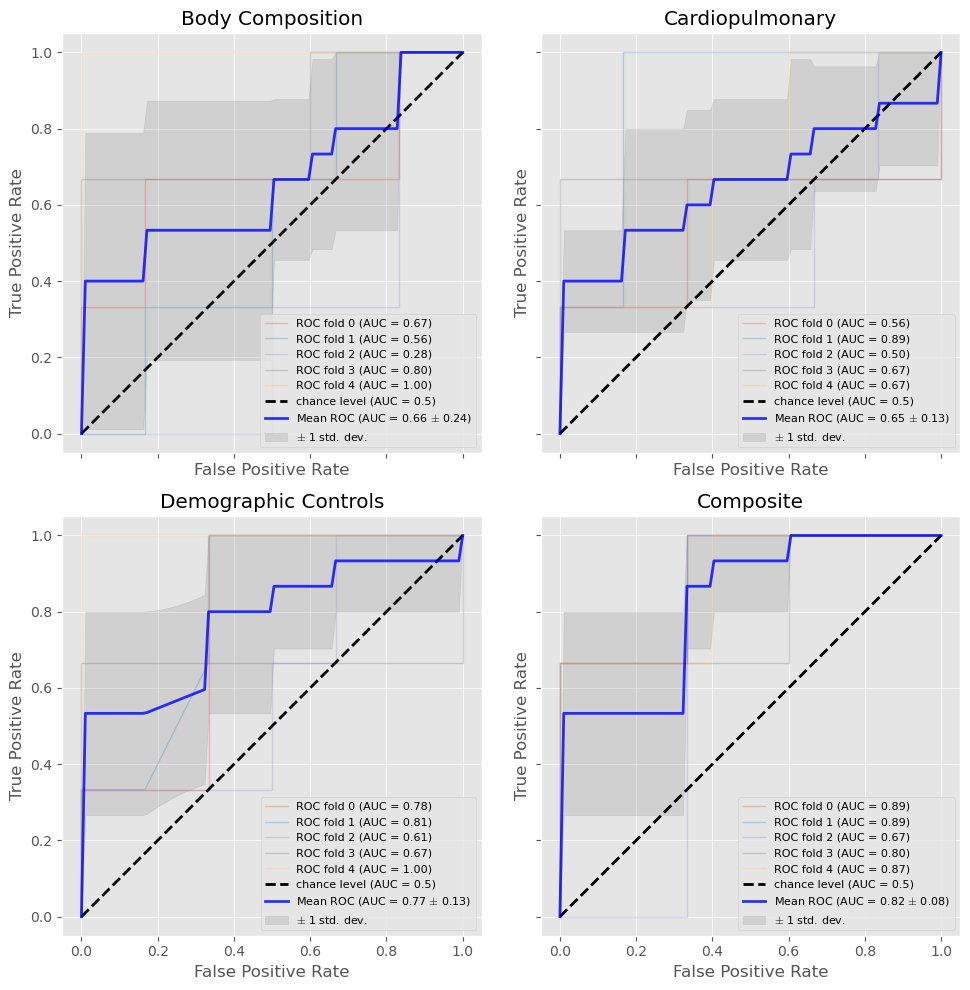

In [142]:
keys = ['body', 'cardio', 'controls', 'composite2']
titles = ['Body Composition', 'Cardiopulmonary', 'Demographic Controls', 'Composite']

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    
    feat = multivariable_model_dfns[keys[i]]
    X_temp = sm.add_constant(X[feat]).reset_index(drop=True)
    y_temp = y.copy().reset_index(drop=True)
    
    cv = StratifiedKFold(n_splits=5)
    classifier = LogisticRegression(
            random_state=SEED,
            fit_intercept=False,
            max_iter=10_000, 
            tol=0.000001,
            penalty=None, 
            solver='newton-cg',
    )
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for fold, (train, test) in enumerate(cv.split(X_temp, y_temp)):
        classifier.fit(X_temp.loc[train, :], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_temp.loc[test, :],
            y_temp[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=titles[i],
    )
    ax.axis("square")
    ax.legend(loc="lower right", fontsize=8)

plt.tight_layout()

plt.savefig('../figures/roc_curves.png')

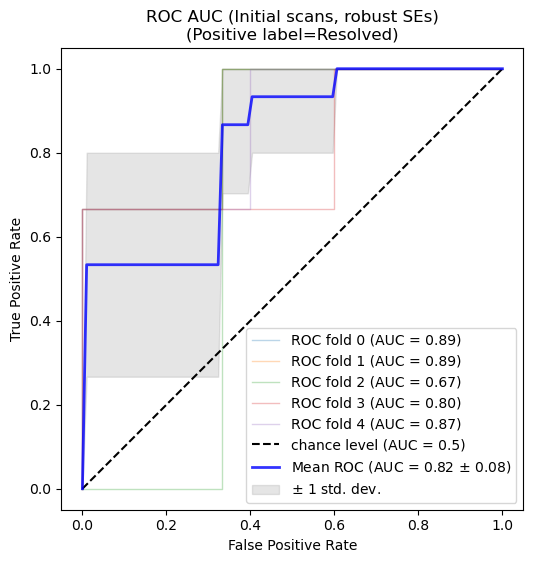

In [100]:
fname = 'roc_curve'
plot_title = 'ROC AUC'
if USE_INITIAL:
    fname += '_initial'
    plot_title += ' (Initial scans, '
else: 
    fname += '_all'
    plot_title += ' (All scans, '
if USE_CLUSTERED_SE:
    fname += '_clustered'
    plot_title += 'clustered SEs)'
else: 
    fname += '_robust'
    plot_title += 'robust SEs)'


feat = composite_model2

X_temp = sm.add_constant(X[feat]).reset_index(drop=True)
y_temp = y.copy().reset_index(drop=True)

cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression(
        random_state=SEED,
        fit_intercept=False,
        max_iter=10_000, 
        tol=0.000001,
        penalty=None, 
        solver='newton-cg',
)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_temp, y_temp)):
    classifier.fit(X_temp.loc[train, :], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_temp.loc[test, :],
        y_temp[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"{plot_title}\n(Positive label=Resolved)",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.savefig(f'../figures/{fname}.png')

plt.show()